# Reading general data of the problems


In [1]:
# coding=utf-8
from __future__ import division
import json
import os
import sys
import multiprocessing

# multiprocessing.set_start_method('spawn')
from MyUtils import clean_folder, read_files, shuffle_docs, shuffle_docs2
from Word2Dim import Word2Dim

dataset_path = '.' + os.sep + 'pan19-cross-domain-authorship-attribution-training-dataset-2019-01-23'
outpath = '.' + os.sep + 'dev_out'

clean_folder(outpath)

infocollection = dataset_path + os.sep + 'collection-info.json'
problems = []
language = []
with open(infocollection, 'r') as f:
    for attrib in json.load(f):
        problems.append(attrib['problem-name'])
        language.append(attrib['language'])
print('Reading general data of the problems, done!')


Reading general data of the problems, done!


# Reading problem 1

In [2]:

problem = problems[0]
index = 0

# used for n_gram extraction and word indexing, a threshold which prevent words appearing lower than this value to be counted in calculations
tf = 5


infoproblem = dataset_path + os.sep + problem + os.sep + 'problem-info.json'
candidates = []
with open(infoproblem, 'r') as f:
    fj = json.load(f)
    unk_folder = fj['unknown-folder']
    for attrib in fj['candidate-authors']:
        candidates.append(attrib['author-name'])

candidates.sort()
# Building training set
train_docs = []
for candidate in candidates:
    train_docs.extend(read_files(dataset_path + os.sep + problem, candidate))
train_texts = [text for i, (text, label) in enumerate(train_docs)]
train_labels = [label for i, (text, label) in enumerate(train_docs)]
initial_train_size = len(train_labels)

train_texts, train_labels = shuffle_docs(train_texts, train_labels)
validation_size = len(train_texts) - initial_train_size
class_size = int(initial_train_size / len(set(train_labels)))

# train_texts, train_labels, validation_start_index, class_size = shuffle_docs2(train_texts, train_labels)

index_2_label_dict = {i: l for i, l in enumerate(set(train_labels))}
label_2_index_dict = {l: i for i, l in enumerate(set(train_labels))}
train_labels = [label_2_index_dict[v] for v in train_labels]
w2d = Word2Dim(lang= language[index])
train_tokenized_with_pos, train_tokenized_indexed = w2d.fit_transform_texts(train_texts, train_labels, tf= tf)

maxlen = len(max(train_tokenized_indexed, key=len))  # We will cut the texts after # words
embedding_dim = w2d.word_embedding.shape[1]

# preparing test set
ground_truth_file = dataset_path + os.sep + problem + os.sep + 'ground-truth.json'
gt = {}
with open(ground_truth_file, 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

test_docs = read_files(dataset_path + os.sep + problem, unk_folder, gt)
test_texts = [text for i, (text, label) in enumerate(test_docs)]
test_labels = [label for i, (text, label) in enumerate(test_docs)]

# Filter validation to known authors
test_texts = [text for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]
test_labels = [label for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]

test_labels = [label_2_index_dict[v] for v in test_labels]

test_tokenized_with_pos, test_tokenized_indexed = w2d.transform(test_texts)
print("Reading problem 1, done!")

doc count to process:  819
process_doc, done!
word_set, ready!
fit_transform_texts is done!
doc count to process:  468
Reading problem 1, done!


# Data Extraction for Neural Net



In [3]:
from MyUtils import extract_n_grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

n = 3
vocabulary = extract_n_grams(train_docs, n, tf)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n), lowercase=False, vocabulary=vocabulary)
n_gram_train_data = vectorizer.fit_transform(train_texts)

n_gram_train_data = n_gram_train_data.astype(float)

for i, v in enumerate(train_texts):
    n_gram_train_data[i] = n_gram_train_data[i] / len(train_texts[i])
n_gram_test_data = vectorizer.transform(test_texts)
n_gram_test_data = n_gram_test_data.astype(float)
for i, v in enumerate(test_texts):
    n_gram_test_data[i] = n_gram_test_data[i] / len(test_texts[i])
max_abs_scaler = preprocessing.MaxAbsScaler()
scaled_train_data_ngrams = max_abs_scaler.fit_transform(n_gram_train_data)
scaled_test_data_ngrams = max_abs_scaler.transform(n_gram_test_data)
max_abs_scaler = preprocessing.MaxAbsScaler()
scaled_train_data_words = max_abs_scaler.fit_transform(w2d.get_texts_vectorized_and_normalized(train_tokenized_indexed)[:, 1:])
scaled_test_data_words = max_abs_scaler.transform(w2d.get_texts_vectorized_and_normalized(test_tokenized_indexed)[:, 1:])
print("Done!")

Done!


In [4]:
print(scaled_train_data_words.shape)
print(scaled_test_data_words.shape)
print(len(w2d.word_index))

(819, 7623)
(468, 7623)
7623


In [7]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

from numpy import argmax
from sklearn.metrics import accuracy_score
from keras import layers, Input, callbacks
from keras.models import Sequential, Model, load_model
from keras import optimizers, regularizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

callbacks_list_neu = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_neu.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

callbacks_list_neu_ngrams = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_neu_ngrams.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

callbacks_list_neu_words = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_neu_words.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

callbacks_list_convnet = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=35,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_convnet.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=10,
    )
]

callbacks_list_stacked = [
    callbacks.ModelCheckpoint(
        filepath='my_model_stacked.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

# X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=validation_size,
#                                                   stratify=train_labels)
# X_scaled_train_data_words, X_scaled_val_data_words, _, _ = train_test_split(scaled_train_data_words, train_labels,
#                                                   test_size=validation_size,
#                                                   stratify=train_labels)
# X_scaled_train_data_ngrams, X_scaled_val_data_ngrams, _, _ = train_test_split(scaled_train_data_ngrams, train_labels,
#                                                   test_size=validation_size,
#                                                   stratify=train_labels)

# train_val_split_index = validation_start_index
train_val_split_index = initial_train_size
y_train, y_val = train_labels[:train_val_split_index], train_labels[train_val_split_index:]
X_train, X_val = train_data[:train_val_split_index], train_data[train_val_split_index:]
X_scaled_train_data_words, X_scaled_val_data_words = scaled_train_data_words[:train_val_split_index], scaled_train_data_words[train_val_split_index:]
X_scaled_train_data_ngrams, X_scaled_val_data_ngrams = scaled_train_data_ngrams[:train_val_split_index], scaled_train_data_ngrams[train_val_split_index:]

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
# y_test = to_categorical(test_labels)
# print(X_train.shape)

print(y_train.shape)


(63, 9)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                132896    
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 585       
Total para

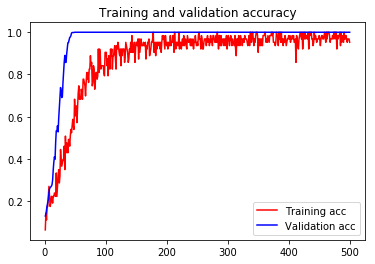

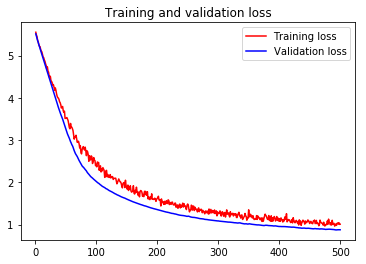

1.0
my_model_neu_ngrams Test Accuracy: 0.880
my_model_neu Test f-measure: 0.749


In [8]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model, load_model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


neu_ng = Sequential()
neu_ng.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_ngrams.shape[1],)))
neu_ng.add(layers.Dropout(0.3))
neu_ng.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_ng.add(layers.Dropout(0.3))
neu_ng.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_ng.add(layers.Dropout(0.3))
neu_ng.add(layers.Dense(len(set(train_labels)), activation='softmax'))

neu_ng.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
neu_ng.summary()
history = neu_ng.fit(X_scaled_train_data_ngrams, y_train,
                    validation_data=(X_scaled_val_data_ngrams, y_val),
                    epochs=500,
                    batch_size=class_size,
                    callbacks=callbacks_list_neu_ngrams,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))
l_model = load_model('my_model_neu_ngrams.h5')
yhat = l_model.predict(scaled_test_data_ngrams)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu_ngrams Test Accuracy: %.3f' % acc)

f_measure = f1_score(test_labels, yhat, average='macro') 

print('my_model_neu Test f-measure: %.3f' % f_measure)


In [7]:
l_model = load_model('my_model_neu_ngrams.h5')
yhat = l_model.predict(scaled_test_data_ngrams)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu_ngrams Test Accuracy: %.3f' % acc)

my_model_neu_ngrams Test Accuracy: 0.825


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                243968    
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 585       
Total para

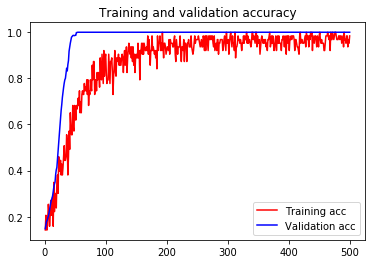

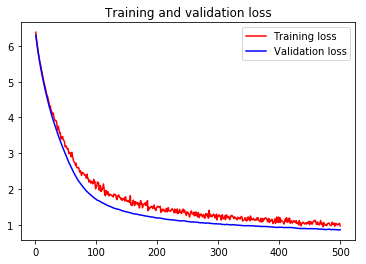

1.0
my_model_neu_words Test Accuracy: 0.915
my_model_neu Test f-measure: 0.796


In [9]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


neu_wo = Sequential()
neu_wo.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_words.shape[1],)))
neu_wo.add(layers.Dropout(0.3))
neu_wo.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_wo.add(layers.Dropout(0.3))
neu_wo.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_wo.add(layers.Dropout(0.3))
neu_wo.add(layers.Dense(len(set(train_labels)), activation='softmax'))


neu_wo.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
neu_wo.summary()
history = neu_wo.fit(X_scaled_train_data_words, y_train,
                    validation_data=(X_scaled_val_data_words, y_val),
                    epochs=500,
                    batch_size=class_size,
                    callbacks=callbacks_list_neu_words,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))
l_model = load_model('my_model_neu_words.h5')
yhat = l_model.predict( scaled_test_data_words)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu_words Test Accuracy: %.3f' % acc)
f_measure = f1_score(test_labels, yhat, average='macro') 

print('my_model_neu Test f-measure: %.3f' % f_measure)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
n_grams (InputLayer)            (None, 4152)         0                                            
__________________________________________________________________________________________________
words (InputLayer)              (None, 7623)         0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 64)           139168      n_grams[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 64)           250240      words[0][0]                      
__________________________________________________________________________________________________
concatenat

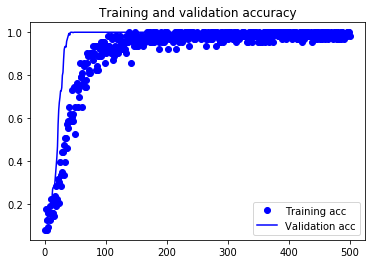

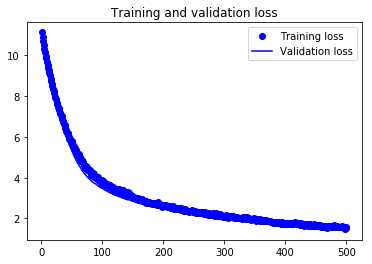

1.0
my_model_neu Test Accuracy: 0.878
my_model_neu Test f-measure: 0.768


In [10]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model, load_model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

word_input_tensor = Input(shape=(scaled_train_data_words.shape[1],) , name='words')
ngram_input_tensor = Input(shape=(scaled_train_data_ngrams.shape[1],) , name='n_grams')

neu0 = Sequential()
neu0.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_ngrams.shape[1],)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))

neu1 = Sequential()
neu1.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_words.shape[1],)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))

output_tensor_0 = neu0(ngram_input_tensor)
output_tensor_1 = neu1(word_input_tensor)


# conv_input_tensor = Input(shape=(maxlen,) , name='convnets')

# conv_1d_s3_model = Sequential()
# conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_s3_model.add(layers.Dropout(0.2))
# conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# conv_1d_s3_model.add(layers.BatchNormalization())
# conv_1d_s3_model.add(layers.GlobalMaxPooling1D())

# conv_output_tensor_0 = conv_1d_s3_model(conv_input_tensor)


# conv_1d_s1_model = Sequential()
# conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_s1_model.add(layers.Dropout(0.2))
# conv_1d_s1_model.add(layers.SeparableConv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.GlobalMaxPooling1D())

# conv_output_tensor_1 = conv_1d_s1_model(conv_input_tensor)

# conv_1d_complex_model = Sequential()
# conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_complex_model.add(layers.Dropout(0.2))
# conv_1d_complex_model.add(layers.SeparableConv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_complex_model.add(layers.GlobalMaxPooling1D())

# conv_output_tensor_2 = conv_1d_complex_model(conv_input_tensor)



concatenated = layers.concatenate([output_tensor_0,
                                   output_tensor_1,
#                                    conv_output_tensor_0,
#                                    conv_output_tensor_1,
#                                    conv_output_tensor_2,
                                  ], axis=-1)

concatenated = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
concatenated = layers.Dropout(0.3)(concatenated)
concatenated = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model([ngram_input_tensor, word_input_tensor,
#                conv_input_tensor
              ], concatenated)
model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()
print(X_scaled_train_data_ngrams.shape, X_scaled_train_data_words.shape, y_train.shape) 
history = model.fit([X_scaled_train_data_ngrams, X_scaled_train_data_words, 
#                      X_train
                    ], y_train,
                    validation_data=([X_scaled_val_data_ngrams, X_scaled_val_data_words,
#                                       X_val
                                     ], y_val),
                    epochs=500,
                    batch_size=class_size,
                    callbacks=callbacks_list_neu,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))
l_model = load_model('my_model_neu.h5')
yhat = l_model.predict([scaled_test_data_ngrams, scaled_test_data_words])
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu Test Accuracy: %.3f' % acc)
f_measure = f1_score(test_labels, yhat, average='macro') 

print('my_model_neu Test f-measure: %.3f' % f_measure)

In [15]:
l_model = load_model('my_model_neu.h5')
yhat = l_model.predict([scaled_test_data_ngrams, scaled_test_data_words])
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)

print('my_model_neu Test Accuracy: %.3f' % acc)

f_measure = f1_score(test_labels, yhat, average='macro') 

print('my_model_neu Test f-measure: %.3f' % f_measure)

my_model_neu Test Accuracy: 0.853
my_model_neu Test f-measure: 0.668


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
convnet_words (InputLayer)      (None, 1053)         0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 64)           72451       convnet_words[0][0]              
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 64)           69521       convnet_words[0][0]              
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 64)           72378       convnet_words[0][0]              
__________________________________________________________________________________________________
concatenat

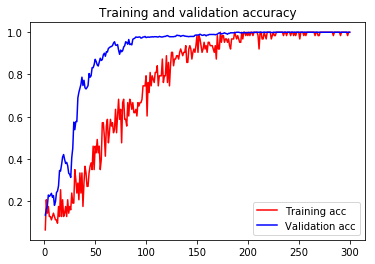

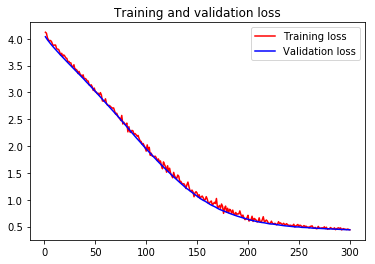

my_model_convnet Test Accuracy: 0.372
my_model_neu Test f-measure: 0.322


c:\users\designer\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

convnet_input_tensor = Input(shape=(maxlen,) , name='convnet_words')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s3_model.add(layers.Dropout(0.3))
conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s3_model.add(layers.BatchNormalization())
conv_1d_s3_model.add(layers.MaxPooling1D(2))
conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu'))
conv_1d_s3_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s3_model.add(layers.BatchNormalization())
# conv_1d_s3_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s3_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s3_model.layers[0].trainable = False
conv_output_tensor_0 = conv_1d_s3_model(convnet_input_tensor)


conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s1_model.add(layers.Dropout(0.3))
conv_1d_s1_model.add(layers.SeparableConv1D(64, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.MaxPooling1D(2))
# conv_1d_s1_model.add(layers.SeparableConv1D(32, 3, activation='relu'))
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s1_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s1_model.layers[0].trainable = False
conv_output_tensor_1 = conv_1d_s1_model(convnet_input_tensor)

conv_1d_complex_model = Sequential()
conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_complex_model.add(layers.Dropout(0.3))
conv_1d_complex_model.add(layers.SeparableConv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
conv_1d_complex_model.add(layers.MaxPooling1D(2))
conv_1d_complex_model.add(layers.SeparableConv1D(32, 2, activation='relu'))
conv_1d_complex_model.add(layers.SeparableConv1D(64, 2, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
conv_1d_complex_model.add(layers.GlobalMaxPooling1D())
# conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_complex_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_complex_model.layers[0].trainable = False
conv_output_tensor_2 = conv_1d_complex_model(convnet_input_tensor)

# x = layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen)(word_input_tensor)
# x = layers.Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
# x = layers.Dropout(0.2)(x)
# x = layers.BatchNormalization()(x)
# y = layers.Conv1D(128, 10, activation='relu', padding='same')(x)
# added = layers.add([y, x])
# added = layers.GlobalMaxPooling1D()(added)

concatenated = layers.concatenate([conv_output_tensor_0,
                                   conv_output_tensor_1,
                                   conv_output_tensor_2,
#                                    ,added
                                  ], axis=-1)
concatenated = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
concatenated = layers.Dropout(0.3)(concatenated)
# concatenated = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
# concatenated = layers.Dropout(0.3)(concatenated)
answer = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model(convnet_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=300,
                    batch_size=class_size,
                    callbacks=callbacks_list_convnet,
                    verbose= 2
                   )

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
l_model = load_model('my_model_convnet.h5')
yhat = l_model.predict(test_data)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_convnet Test Accuracy: %.3f' % acc)
f_measure = f1_score(test_labels, yhat, average='macro') 

print('my_model_neu Test f-measure: %.3f' % f_measure)

In [14]:
l_model = load_model('my_model_convnet.h5')
yhat = l_model.predict(test_data)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_convnet Test Accuracy: %.3f' % acc)

my_model_convnet Test Accuracy: 0.434


In [12]:
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack
from keras.utils import plot_model
from keras.layers.merge import concatenate

# load models from file
def load_all_models(model_names_list):
    all_models = list()
    for model_name in model_names_list:
        # define filename for this ensemble
#         filename = 'models/model_' + str(i + 1) + '.h5'
        filename = model_name + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models


# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer.name = 'ensemble_' + str(i + 1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
#     print(ensemble_visible)
#     ensemble_visible = [[ngram_input_tensor, word_input_tensor], convnet_input_tensor]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
#     ensemble_outputs = [concatenated, answer]
    merge = concatenate(ensemble_outputs)
    hidden = layers.Dense(128, activation='relu')(merge)
    hidden = layers.Dropout(0.3)(hidden)
    output = layers.Dense(len(set(train_labels)), activation='softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
#     plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=3e-4), metrics=['accuracy'])
    return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy, valX, valy):
    # prepare input data
#     X = [inputX for _ in range(len(model.input))]
    # encode output data
#     inputy_enc = to_categorical(inputy)
    # fit model
    model.fit(inputX, inputy, validation_data=(valX, valy), batch_size=class_size,
              callbacks=callbacks_list_stacked, epochs=300, verbose=1)
    
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
#     X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(inputX, verbose=0)

print('done!')

done!


In [13]:

members = load_all_models(['my_model_neu_ngrams', 'my_model_neu_words'
#                            , 'my_model_convnet'
                          ])
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, [X_scaled_train_data_ngrams, X_scaled_train_data_words, 
#                                   X_train
                                 ], y_train, [X_scaled_val_data_ngrams, X_scaled_val_data_words, 
#                                               X_val
                                             ], y_val)
final_model = load_model('my_model_stacked.h5')
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, [scaled_test_data_ngrams, scaled_test_data_words
#                                              , test_data
                                            ])
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('Stacked Test Accuracy: %.3f' % acc)
f_measure = f1_score(test_labels, yhat, average='macro') 

print('my_model_neu Test f-measure: %.3f' % f_measure)

>loaded my_model_neu_ngrams.h5
>loaded my_model_neu_words.h5
Loaded 2 models
Train on 63 samples, validate on 756 samples
Epoch 1/300
63/63 [==============================] - 3s 41ms/step - loss: 3.9079 - acc: 0.1429 - val_loss: 3.8629 - val_acc: 0.3333
Epoch 2/300
63/63 [==============================] - 0s 6ms/step - loss: 3.8379 - acc: 0.2857 - val_loss: 3.8268 - val_acc: 0.3333
Epoch 3/300
63/63 [==============================] - 0s 5ms/step - loss: 3.8053 - acc: 0.3175 - val_loss: 3.7904 - val_acc: 0.3333
Epoch 4/300
63/63 [==============================] - 0s 6ms/step - loss: 3.8103 - acc: 0.3016 - val_loss: 3.7539 - val_acc: 0.4444
Epoch 5/300
63/63 [==============================] - 0s 5ms/step - loss: 3.7466 - acc: 0.4286 - val_loss: 3.7172 - val_acc: 0.4444
Epoch 6/300
63/63 [==============================] - 0s 5ms/step - loss: 3.7234 - acc: 0.4127 - val_loss: 3.6803 - val_acc: 0.5556
Epoch 7/300
63/63 [==============================] - 0s 5ms/step - loss: 3.7067 - acc: 0.52

In [14]:

members = load_all_models(['my_model_neu_ngrams', 'my_model_neu_words'
                           , 'my_model_convnet'
                          ])
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, [X_scaled_train_data_ngrams, X_scaled_train_data_words, 
                                  X_train
                                 ], y_train, [X_scaled_val_data_ngrams, X_scaled_val_data_words, 
                                              X_val
                                             ], y_val)
final_model = load_model('my_model_stacked.h5')
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, [scaled_test_data_ngrams, scaled_test_data_words
                                             , test_data
                                            ])
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('Stacked Test Accuracy: %.3f' % acc)
f_measure = f1_score(test_labels, yhat, average='macro') 

print('my_model_neu Test f-measure: %.3f' % f_measure)

>loaded my_model_neu_ngrams.h5
>loaded my_model_neu_words.h5
>loaded my_model_convnet.h5
Loaded 3 models
Train on 63 samples, validate on 756 samples
Epoch 1/300
63/63 [==============================] - 5s 80ms/step - loss: 3.9155 - acc: 0.1587 - val_loss: 3.8627 - val_acc: 0.1111
Epoch 2/300
63/63 [==============================] - 2s 29ms/step - loss: 3.8519 - acc: 0.2381 - val_loss: 3.8124 - val_acc: 0.3333
Epoch 3/300
63/63 [==============================] - 2s 29ms/step - loss: 3.7983 - acc: 0.3016 - val_loss: 3.7636 - val_acc: 0.5556
Epoch 4/300
63/63 [==============================] - 2s 29ms/step - loss: 3.7734 - acc: 0.4127 - val_loss: 3.7152 - val_acc: 0.6667
Epoch 5/300
63/63 [==============================] - 2s 28ms/step - loss: 3.7127 - acc: 0.4444 - val_loss: 3.6685 - val_acc: 0.6667
Epoch 6/300
63/63 [==============================] - 2s 29ms/step - loss: 3.6766 - acc: 0.6667 - val_loss: 3.6220 - val_acc: 0.7778
Epoch 7/300
63/63 [==============================] - 2s 29

In [16]:
f_measure = f1_score(test_labels, yhat, average='macro') 

print('my_model_neu Test f-measure: %.3f' % f_measure)

my_model_neu Test f-measure: 0.668
